In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import math

from scipy.stats import wilcoxon
from matplotlib import pyplot as plt
from utils.plot_utils import radar_factory, load_results, load_ece_results
from utils.stat_utils import bootstrap_noninferiority_test, bootstrap_superiority_test

%matplotlib inline

### Plot specifications

In [2]:
tasks = [
    'hospital_mortality', 'sepsis', 'LOS_7','readmission_30','aki_lab_aki3_label',
    'hyperkalemia_lab_severe_label','hypoglycemia_lab_severe_label','hyponatremia_lab_severe_label',
    'neutropenia_lab_severe_label','anemia_lab_severe_label','thrombocytopenia_lab_severe_label'
]

titles = {
    'hospital_mortality':'Hospital Mortality', 
    'sepsis':'Sepsis', 
    'LOS_7':'Long LOS', 
    'readmission_30':'30-day Readmission', 
    'aki_lab_aki1_label':'Acute Kidney Injury',
    'aki_lab_aki3_label':'Acute Kidney Injury',
    'hyperkalemia_lab_mild_label':'Hyperkalemia',
    'hyperkalemia_lab_severe_label':'Hyperkalemia',
    'hypoglycemia_lab_mild_label': 'Hypoglycemia',
    'hypoglycemia_lab_severe_label':'Hypoglycemia',
    'hyponatremia_lab_mild_label':'Hyponatremia',
    'hyponatremia_lab_severe_label':'Hyponatremia',
    'neutropenia_lab_mild_label':'Neutropenia',
    'neutropenia_lab_severe_label':'Neutropenia',
    'anemia_lab_mild_label':'Anemia',
    'anemia_lab_severe_label':'Anemia',
    'thrombocytopenia_lab_mild_label':'Thrombocytopenia',
    'thrombocytopenia_lab_severe_label':'Thrombocytopenia'
    }

model_colours = {
    '$Count-LR_{Peds}$':'black',
    '$CLMBR_{Peds}-LR_{Peds}$':'dimgrey',
    '$Count-GBM_{Peds}$':'darkgrey',
    '$CLMBR_{Combined}-LR_{Adults}[ID]$':'purple',
    '$CLMBR_{Combined}-LR_{Peds}$':'purple',
    '$CLMBR_{Adults}-LR_{Adults}$':'indianred',
    '$CLMBR_{Adults}-LR_{Adults}[ID]$':'indianred',
    '$CLMBR_{Adults}-LR_{Peds}$':'lightseagreen',
    '$CLMBR_{FT-Pre}-LR_{Peds}$':'teal',
}

### Radar Charts for Primary, Secondary, and Exploratory Analyses

missing ad_no_ped ad hospital_mortality eval
missing ad_no_ped ad sepsis eval
missing ad_no_ped ad LOS_7 eval
missing ad_no_ped ad readmission_30 eval
missing ad_no_ped ad aki_lab_aki3_label eval
missing ad_no_ped ad hyperkalemia_lab_severe_label eval
missing ad_no_ped ad hypoglycemia_lab_severe_label eval
missing ad_no_ped ad hyponatremia_lab_severe_label eval
missing ad_no_ped ad neutropenia_lab_severe_label eval
missing ad_no_ped ad anemia_lab_severe_label eval
missing ad_no_ped ad thrombocytopenia_lab_severe_label eval
missing mix ad hospital_mortality eval
missing mix ad sepsis eval
missing mix ad LOS_7 eval
missing mix ad readmission_30 eval
missing mix ad aki_lab_aki3_label eval
missing mix ad hyperkalemia_lab_severe_label eval
missing mix ad hypoglycemia_lab_severe_label eval
missing mix ad hyponatremia_lab_severe_label eval
missing mix ad neutropenia_lab_severe_label eval
missing mix ad anemia_lab_severe_label eval
missing mix ad thrombocytopenia_lab_severe_label eval


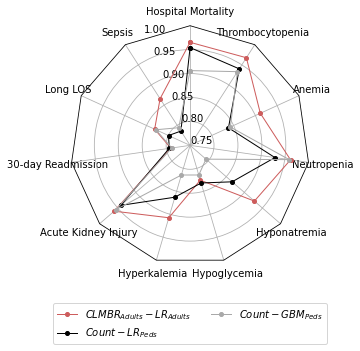

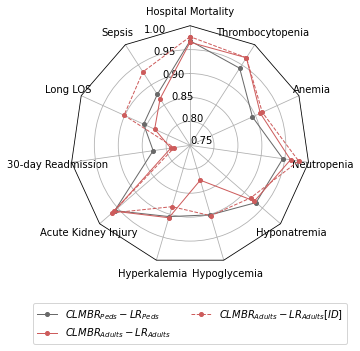

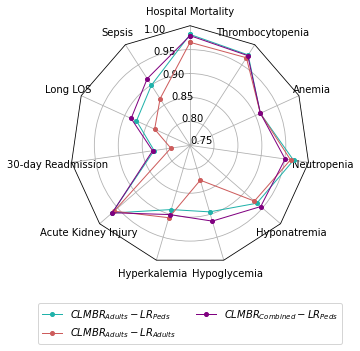

In [3]:
plot_dict = load_results()
N = 11
theta = radar_factory(N, frame='polygon')

scenarios = [['p1', 'p2'],['s1','s2'],['e1','e2','e3','e4','e5', 'e6']]
for scenario in scenarios:
    
    fig, ax = plt.subplots(
        nrows=1,ncols=1,
        figsize=(5,5), 
        subplot_kw=dict(projection='radar')
    )
    
    models = {}
    for s in scenario:
        models={
            **models,
            **{
                x:s for x in plot_dict[s]['auc'].Model.unique().tolist()
                if x not in models
            },
        }
        
    df = pd.concat((
        plot_dict[s]['auc'].query("Model==@m")
        for m,s in models.items()
    ))
    
    df = df.replace({'Tasks':{**titles}})

    models = df.Model.unique()
    models_c = [model_colours[x] for x in models]

    data = [
        df.Tasks.unique().tolist(),
        (
            'auc', 
            [
                df.query("Model==@x").Performance.tolist()
                for x in df.Model.unique()
            ]
        )
    ]

    spoke_labels = data.pop(0)
    _, case_data = data[0]

    for i,d in enumerate(case_data):
        line = ax.plot(
            theta,d,
            marker='o',
            linestyle='--' if scenario==['s1','s2'] and (i==2 or i==3) else '-',
            markersize=4,
            c=models_c[i],
            linewidth=1,
            label=models[i],
            zorder=100
        )

    ax.set_rlim([0.75,1])
    #ax.set_title(analysis)
    ax.set_varlabels(spoke_labels,**{'color':'black'})

    plt.tight_layout()

    ax.legend(ncol=2,loc="lower center", bbox_to_anchor = (0.5,-0.35))
    fname = '_'.join(scenario)
    plt.savefig(f'figures/fig_{fname}.png',dpi=300,bbox_inches='tight', pad_inches=0.5)
    plt.show()

#### Stats

In [4]:
# #get margin for non-inferiority test
# count_source = plot_dict['for_margin']['auc'].query("Model=='$Count-LR_{Adults}$'")['Performance'].values
# count_target = plot_dict['for_margin']['auc'].query("Model=='$Count-LR_{Peds}$'")['Performance'].values

In [5]:
# np.random.seed(44)
# nboot=10000
# nsamples=len(count_source)

# diffs = np.empty(nboot)
# diffs[:]=np.nan
# for iboot in range(nboot):
#     ids = np.random.choice(nsamples,nsamples,replace=True)
#     diffs[iboot] = np.mean(count_target[ids]/count_source[ids])
    
# margin = 0.5 * ((np.percentile(diffs,[2.5])-1)*100)[0]

In [4]:
def bootstrap_noninferiority_test(
    treatment:np.ndarray, 
    control:np.ndarray, 
    margin:float=0.05, 
    n_boot:int=10000,
    seed:int=444,
    higher_is_better:bool=True,
    )->(float,float,list):
    """
    
    """
    assert(len(treatment)==len(control))
    
    np.random.seed(seed)
    diffs = np.empty(n_boot)
    diffs[:] = np.nan
    
    for i in range(n_boot):
        ids = np.random.choice(len(treatment),len(treatment),replace=True)
        diffs[i] = np.mean(treatment[ids] - control[ids])
    
    if higher_is_better:
        p = np.sum(diffs<(-margin*np.mean(control)))/len(diffs) + 0.5*np.sum(diffs==(-margin*np.mean(control)))/len(diffs)
    else:
        p = np.sum(diffs>(-margin*np.mean(control)))/len(diffs) + 0.5*np.sum(diffs==(-margin*np.mean(control)))/len(diffs)
        
    return (2*min(p, 1-p), np.mean(diffs), np.percentile(diffs,[2.5,97.5]), diffs)

def bootstrap_superiority_test(
    treatment:np.ndarray, 
    control:np.ndarray, 
    n_boot:int=10000,
    seed:int=444,
    higher_is_better:bool=True,
    )->(float,float,list):
    """
    
    """
    assert(len(treatment)==len(control))
    
    np.random.seed(seed)
    diffs = np.empty(n_boot)
    diffs[:] = np.nan
    
    for i in range(n_boot):
        ids = np.random.choice(len(treatment),len(treatment),replace=True)
        diffs[i] = np.mean(treatment[ids] - control[ids])
    
    if higher_is_better:
        p = np.sum(diffs<=0)/len(diffs)
    else:
        p = np.sum(diffs>=0)/len(diffs)
        
    return (2*min(p, 1-p), np.mean(diffs), np.percentile(diffs,[2.5,97.5]), diffs)

In [5]:
def get_summary(x):
    print(x.mean(),'\n', x.quantile([0.25,0.5,0.75]))
margin = 0.05
for analysis, items in plot_dict.items():
    
    if analysis=='for_margin':continue
    
    m1,m2 = items['auc'].Model.unique()
    
    print(f"=========={analysis}: {m1} (treatment) vs {m2} (control)===============")
    for metric in ['auc']:
        x = items[metric].query("Model==@m1").Performance
        y = items[metric].query("Model==@m2").Performance

        print(f"{metric}")
#         w,p = wilcoxon(x,y)
#         print(f"p-value: {p}")
        
        # add non-inferiority test for primary analysis
        if analysis=='p1' or analysis=='p2':
            p,m,ci, diffs = bootstrap_noninferiority_test(x.to_numpy(),y.to_numpy(),margin=margin)
            print(f"non-inferiority test: p={p}; mean={m}; ci={ci}")
        p,m,ci, diffs = bootstrap_superiority_test(x.to_numpy(),y.to_numpy())
        print(f"superiority test: p={p}; mean={m}; ci={ci}")

            
        print(m1)
        get_summary(x)
        print(m2)
        get_summary(y)
        print("difference")
        get_summary(x-y)
#     if m1 == "$CLMBR_{Adults}-LR_{Adults}[ID]$":
#         break

==========p1: $CLMBR_{Adults}-LR_{Adults}$ (treatment) vs $Count-LR_{Peds}$ (control)===============
auc
non-inferiority test: p=0.0; mean=0.03390210358264699; ci=[0.01786633 0.05037702]
superiority test: p=0.0; mean=0.03390210358264699; ci=[0.01786633 0.05037702]
$CLMBR_{Adults}-LR_{Adults}$
0.9013822375044498 
 0.25    0.848612
0.50    0.911348
0.75    0.960963
Name: Performance, dtype: float64
$Count-LR_{Peds}$
0.8675384416967341 
 0.25    0.815709
0.50    0.862864
0.75    0.934528
Name: Performance, dtype: float64
difference
0.03384379580771558 
 0.25    0.014737
0.50    0.031858
0.75    0.053130
Name: Performance, dtype: float64
==========p2: $CLMBR_{Adults}-LR_{Adults}$ (treatment) vs $Count-GBM_{Peds}$ (control)===============
auc
non-inferiority test: p=0.0; mean=0.04404576836094301; ci=[0.01993195 0.0698655 ]
superiority test: p=0.0; mean=0.04404576836094301; ci=[0.01993195 0.0698655 ]
$CLMBR_{Adults}-LR_{Adults}$
0.9013822375044498 
 0.25    0.848612
0.50    0.911348
0.75    

ValueError: not enough values to unpack (expected 2, got 1)

### Sensitivity Analysis using mild lab-based labels

missing ad ad aki_lab_aki1_label eval
missing ad ad hyperkalemia_lab_mild_label eval
missing ad ad hypoglycemia_lab_mild_label eval
missing ad ad hyponatremia_lab_mild_label eval
missing ad ad neutropenia_lab_mild_label eval
missing ad ad anemia_lab_mild_label eval
missing ad ad thrombocytopenia_lab_mild_label eval
missing mix ad aki_lab_aki1_label eval
missing mix ad hyperkalemia_lab_mild_label eval
missing mix ad hypoglycemia_lab_mild_label eval
missing mix ad hyponatremia_lab_mild_label eval
missing mix ad neutropenia_lab_mild_label eval
missing mix ad anemia_lab_mild_label eval
missing mix ad thrombocytopenia_lab_mild_label eval


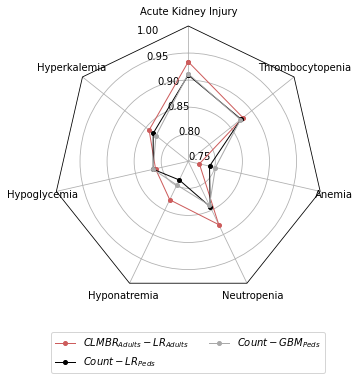

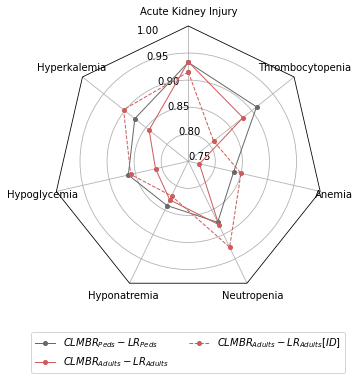

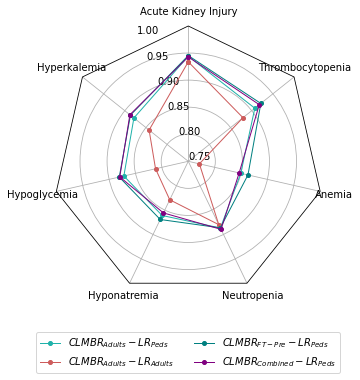

In [12]:
plot_dict = load_results(sensitivity_analysis=True)
N = 7
theta = radar_factory(N, frame='polygon')

scenarios = [['p1','p2'],['s1','s2'],['e1','e2','e3','e4','e5', 'e6']]

for scenario in scenarios:
    
    fig, ax = plt.subplots(
        nrows=1,ncols=1,
        figsize=(5,5), 
        subplot_kw=dict(projection='radar')
    )
    
    models = {}
    for s in scenario:
        models={
            **models,
            **{
                x:s for x in plot_dict[s]['auc'].Model.unique().tolist()
                if x not in models
            },
        }
        
    df = pd.concat((
        plot_dict[s]['auc'].query("Model==@m")
        for m,s in models.items()
    ))
    
    df = df.replace({'Tasks':{**titles}})

    models = df.Model.unique()
    models_c = [model_colours[x] for x in models]

    data = [
        df.Tasks.unique().tolist(),
        (
            'auc', 
            [
                df.query("Model==@x").Performance.tolist()
                for x in df.Model.unique()
            ]
        )
    ]

    spoke_labels = data.pop(0)
    _, case_data = data[0]

    for i,d in enumerate(case_data):
        line = ax.plot(
            theta,d,
            marker='o',
            linestyle='--' if scenario==['s1','s2'] and i==2 else '-',
            markersize=4,
            c=models_c[i],
            linewidth=1,
            label=models[i],
            zorder=100
        )

    ax.set_rlim([0.75,1])
    #ax.set_title(analysis)
    ax.set_varlabels(spoke_labels,**{'color':'black'})

    plt.tight_layout()

    ax.legend(ncol=2,loc="lower center", bbox_to_anchor = (0.5,-0.3))

    fname = '_'.join(scenario)
    plt.savefig(f'figures/fig_{fname}_lab_mild.png',dpi=300,bbox_inches='tight', pad_inches=0.5)
    plt.show()

### Stats

In [7]:
def get_summary(x):
    print(x.mean(),'\n', x.quantile([0.25,0.5,0.75]))
margin = 0.05
for analysis, items in plot_dict.items():
    
    if analysis=='for_margin':continue
    
    m1,m2 = items['auc'].Model.unique()
    
    print(f"=========={analysis}: {m1} (treatment) vs {m2} (control)===============")
    for metric in ['auc']:
        x = items[metric].query("Model==@m1").Performance
        y = items[metric].query("Model==@m2").Performance

        print(f"{metric}")
#         w,p = wilcoxon(x,y)
#         print(f"p-value: {p}")
        
        # add non-inferiority test for primary analysis
        if analysis=='p1' or analysis=='p2':
            p,m,ci, diffs = bootstrap_noninferiority_test(x.to_numpy(),y.to_numpy(),margin=margin)
            print(f"non-inferiority test: p={p}; mean={m}; ci={ci}")
        p,m,ci, diffs = bootstrap_superiority_test(x.to_numpy(),y.to_numpy())
        print(f"superiority test: p={p}; mean={m}; ci={ci}")

        print(m1)
        get_summary(x)
        print(m2)
        get_summary(y)
        print("difference")
        get_summary(x-y)

==========p1: $CLMBR_{Adults}-LR_{Adults}$ (treatment) vs $Count-LR_{Peds}$ (control)===============
auc
non-inferiority test: p=0.0; mean=0.013278266565855552; ci=[-0.00192109  0.02842187]
superiority test: p=0.0898; mean=0.013278266565855552; ci=[-0.00192109  0.02842187]
$CLMBR_{Adults}-LR_{Adults}$
0.849641909628265 
 0.25    0.820455
0.50    0.842566
0.75    0.879561
Name: Performance, dtype: float64
$Count-LR_{Peds}$
0.8364568508384611 
 0.25    0.803333
0.50    0.832932
0.75    0.858925
Name: Performance, dtype: float64
difference
0.013185058789804058 
 0.25    0.000122
0.50    0.009634
0.75    0.030520
Name: Performance, dtype: float64
==========p2: $CLMBR_{Adults}-LR_{Adults}$ (treatment) vs $Count-GBM_{Peds}$ (control)===============
auc
non-inferiority test: p=0.0; mean=0.011470984476157383; ci=[-0.005391   0.0267183]
superiority test: p=0.1808; mean=0.011470984476157383; ci=[-0.005391   0.0267183]
$CLMBR_{Adults}-LR_{Adults}$
0.849641909628265 
 0.25    0.820455
0.50    0.84

### For Main Exp and Sensitivity analysis, plot all CLMBR models

missing ad ad hospital_mortality eval
missing ad ad sepsis eval
missing ad ad LOS_7 eval
missing ad ad readmission_30 eval
missing ad ad aki_lab_aki3_label eval
missing ad ad hyperkalemia_lab_severe_label eval
missing ad ad hypoglycemia_lab_severe_label eval
missing ad ad hyponatremia_lab_severe_label eval
missing ad ad neutropenia_lab_severe_label eval
missing ad ad anemia_lab_severe_label eval
missing ad ad thrombocytopenia_lab_severe_label eval
missing mix ad hospital_mortality eval
missing mix ad sepsis eval
missing mix ad LOS_7 eval
missing mix ad readmission_30 eval
missing mix ad aki_lab_aki3_label eval
missing mix ad hyperkalemia_lab_severe_label eval
missing mix ad hypoglycemia_lab_severe_label eval
missing mix ad hyponatremia_lab_severe_label eval
missing mix ad neutropenia_lab_severe_label eval
missing mix ad anemia_lab_severe_label eval
missing mix ad thrombocytopenia_lab_severe_label eval
missing ad ad aki_lab_aki1_label eval
missing ad ad hyperkalemia_lab_mild_label eval


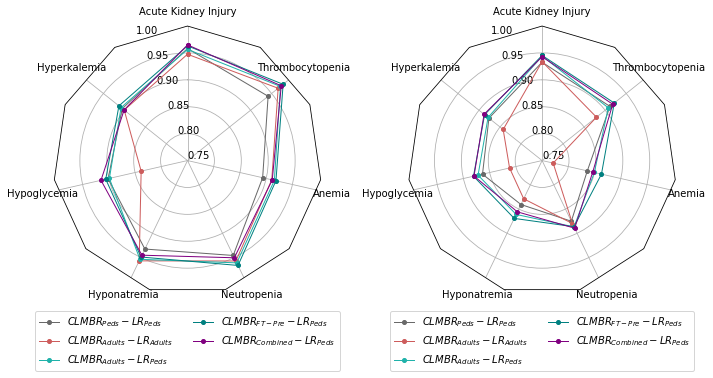

In [14]:
fig, axes = plt.subplots(1,2,figsize=(10,5),subplot_kw=dict(projection='radar'))

s1 = load_results()
s2 = load_results(sensitivity_analysis=True)

models = {
 '$CLMBR_{Peds}-LR_{Peds}$':'s1',
 '$CLMBR_{Adults}-LR_{Adults}$':'p1',
 '$CLMBR_{Adults}-LR_{Peds}$':'e1',
 '$CLMBR_{FT-Pre}-LR_{Peds}$':'e2',
 '$CLMBR_{Combined}-LR_{Peds}$':'e4',
}

tasks = [
    'Acute Kidney Injury',
    'Hyperkalemia',
    'Hypoglycemia',
    'Hyponatremia',
    'Neutropenia',
    'Anemia',
    'Thrombocytopenia'
]

dfs = [
    pd.concat((
        s1[v]['auc'].query("Model==@k")
        for k,v in models.items()
    )),
    pd.concat((
        s2[v]['auc'].query("Model==@k")
        for k,v in models.items()
    )),
]


for c, df in enumerate(dfs):
    
    df = df.replace({'Tasks':{**titles}})
    df = df.query("Tasks==@tasks")
    N = df.Tasks.nunique()        
    theta = radar_factory(N, frame='polygon')
    
    models = df.Model.unique()
    models_c = [model_colours[x] for x in models]

    data = [
        df.Tasks.unique().tolist(),
        (
            'auc', 
            [
                df.query("Model==@x").Performance.tolist()
                for x in df.Model.unique()
            ]
        )
    ]

    spoke_labels = data.pop(0)
    _, case_data = data[0]

    for i,d in enumerate(case_data):
        line = axes[c].plot(
            theta,d,
            marker='o',
            markersize=4,
            c=models_c[i],
            linewidth=1,
            label=models[i],
            zorder=100
        )

    axes[c].set_rlim([0.75,1])
    #ax.set_title(analysis)
    axes[c].set_xticks(theta)
    axes[c].set_xticklabels(spoke_labels)
    plt.tight_layout()
    axes[c].legend(ncol=2,loc="lower center", bbox_to_anchor = (0.5,-0.3))
plt.savefig(f'figures/all_clmbr.png',dpi=300,bbox_inches='tight')
plt.show()

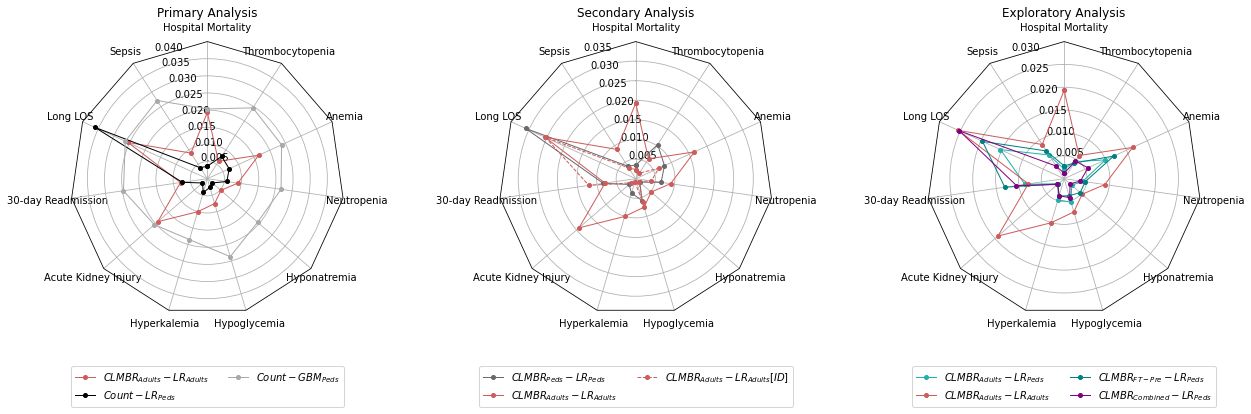

In [13]:
# radarplot for ECE values
plot_dict = load_ece_results()
N = 11
theta = radar_factory(N, frame='polygon')

scenarios = [['p'],['s'],['e']]

fig, ax = plt.subplots(
    nrows=1,ncols=3,
    figsize=(18,6), 
    subplot_kw=dict(projection='radar')
)

for j, scenario in enumerate(scenarios):
    
    models = {}
    for s in scenario:
        models={
            **models,
            **{
                x:s for x in plot_dict[s].Model.unique().tolist()
                if x not in models
            },
        }
        
    df = pd.concat((
        plot_dict[s].query("Model==@m")
        for m,s in models.items()
    ))
    
    df = df.replace({'Tasks':{**titles}})
    models = df.Model.unique()
    models_c = [model_colours[x] for x in models]

    data = [
        df.Tasks.unique().tolist(),
        (
            'ece', 
            [
                df.query("Model==@x").Performance.tolist()
                for x in df.Model.unique()
            ]
        )
    ]

    spoke_labels = data.pop(0)
    _, case_data = data[0]

    for i,d in enumerate(case_data):
        line = ax[j].plot(
            theta,d,
            marker='o',
            linestyle='--' if scenario==['s'] and i==2 else '-',
            markersize=4,
            c=models_c[i],
            linewidth=1,
            label=models[i],
            zorder=100
        )
    if scenario == ['p']:
        ax[j].set_title('Primary Analysis')
        ax[j].set_rlim([0.0,0.04])
    elif scenario == ['s']:
        ax[j].set_title('Secondary Analysis')
        ax[j].set_rlim([0.0,0.035])
    elif scenario == ['e']:
        ax[j].set_title('Exploratory Analysis')
        ax[j].set_rlim([0.0,0.03])        
    #ax.set_title(analysis)
    ax[j].set_varlabels(spoke_labels,**{'color':'black'})


    plt.tight_layout()
    ax[j].legend(ncol=2,loc="lower center", bbox_to_anchor = (0.5,-0.35))

plt.savefig(f'figures/ece_radarplots_combined.png',dpi=300,bbox_inches='tight')
plt.show()

## Sanity check/sensitivity analysis comparing Count-LR_Adult ID vs OOD

In [10]:
tasks = [
    'hospital_mortality', 'sepsis', 'LOS_7','readmission_30','aki_lab_aki3_label',
    'hyperkalemia_lab_severe_label','hypoglycemia_lab_severe_label','hyponatremia_lab_severe_label',
    'neutropenia_lab_severe_label','anemia_lab_severe_label','thrombocytopenia_lab_severe_label'
]

metrics = ['auc', 'auprc', 'ace_abs_logistic_logit']

model_path = '/local-scratch/nigam/projects/jlemmon/transfer_learning/experiments/artifacts/models'
results_path = '/local-scratch/nigam/projects/jlemmon/transfer_learning/experiments/artifacts/results'
best_clmbr_params = {'all':'gru_sz_800_do_0_lr_0.0001_l2_0', 'mix':'gru_sz_800_do_0_lr_0.0001_l2_0'}

feat_groups = ['shared']
cohort_types = ['pediatric', 'adult']

# Get baseline model
lr_df = pd.DataFrame()
for task in tasks:
    for trc in ['adult', 'pediatric']:
        for tstc in ['pediatric', 'adult']:
            for fg in feat_groups:
                df = pd.read_csv(f'{results_path}/lr/{task}/tr_{trc}_tst_{tstc}/shared_feats/best/test_eval.csv')
                df['task'] = task
                df['train_cohort'] = trc
                df['test_cohort'] = tstc
                df['cohort'] = trc
                df['model'] = 'LR'
                df['feature_group'] = fg
                lr_df = pd.concat([lr_df,df])

metrics = ['auc']
plot_dict = {}
plot_dict['a'] = {}
for metric in metrics:
    plot_dict['a'][metric] = pd.DataFrame()
    lr_source = lr_df.query("train_cohort=='adult' and metric==@metric and feature_group=='shared' and test_cohort=='adult'")[['performance', 'task']]
    df = pd.DataFrame({'Performance':lr_source['performance'],'Tasks':lr_source['task'],'Model':'$Count-LR_{Adults}[ID]$'})
    plot_dict['a'][metric] = pd.concat((plot_dict['a'][metric],df))

    lr_target = lr_df.query("train_cohort=='adult' and metric==@metric and feature_group=='shared' and test_cohort=='pediatric'")[['performance', 'task']]
    df = pd.DataFrame({'Performance':lr_target['performance'],'Tasks':lr_target['task'],'Model':'$Count-LR_{Adults}$'})
    plot_dict['a'][metric] = pd.concat((plot_dict['a'][metric],df))

def get_summary(x):
    print(x.mean(),'\n', x.quantile([0.25,0.5,0.75]))
margin = 0.05
for analysis, items in plot_dict.items():
    
    if analysis=='for_margin':continue
    
    m1,m2 = items['auc'].Model.unique()
    
    print(f"=========={analysis}: {m1} (treatment) vs {m2} (control)===============")
    for metric in ['auc']:
        x = items[metric].query("Model==@m1").Performance
        y = items[metric].query("Model==@m2").Performance

        print(f"{metric}")
#         w,p = wilcoxon(x,y)
#         print(f"p-value: {p}")
        
        # add non-inferiority test for primary analysis
        if analysis=='p1' or analysis=='p2':
            p,m,ci, diffs = bootstrap_noninferiority_test(x.to_numpy(),y.to_numpy(),margin=margin)
            print(f"non-inferiority test: p={p}; mean={m}; ci={ci}")
        p,m,ci, diffs = bootstrap_superiority_test(x.to_numpy(),y.to_numpy())
        print(f"superiority test: p={p}; mean={m}; ci={ci}")

        print(m1)
        get_summary(x)
        print(m2)
        get_summary(y)
        print("difference")
        get_summary(x-y)

==========a: $Count-LR_{Adults}[ID]$ (treatment) vs $Count-LR_{Adults}$ (control)===============
auc
superiority test: p=0.0; mean=0.06664340943124775; ci=[0.03940539 0.09544539]
$Count-LR_{Adults}[ID]$
0.8811579878609628 
 0.25    0.845812
0.50    0.872792
0.75    0.929456
Name: Performance, dtype: float64
$Count-LR_{Adults}$
0.8145258795025758 
 0.25    0.752625
0.50    0.799970
0.75    0.888720
Name: Performance, dtype: float64
difference
0.06663210835838704 
 0.25    0.035335
0.50    0.067231
0.75    0.093847
Name: Performance, dtype: float64


In [ ]:
# make clmbr info copy with different values
# re-featurize and test a task